# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [34]:
import pickle
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.nn as nn
from torch.optim import lr_scheduler

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
!unzip -q /content/gdrive/MyDrive/train.zip -d train
!unzip -q /content/gdrive/MyDrive/testset.zip -d test

In [5]:
!ls train/train

abraham_grampa_simpson	  groundskeeper_willie	ned_flanders
agnes_skinner		  homer_simpson		nelson_muntz
apu_nahasapeemapetilon	  kent_brockman		otto_mann
barney_gumble		  krusty_the_clown	patty_bouvier
bart_simpson		  lenny_leonard		principal_skinner
carl_carlson		  lionel_hutz		professor_john_frink
charles_montgomery_burns  lisa_simpson		rainier_wolfcastle
chief_wiggum		  maggie_simpson	ralph_wiggum
cletus_spuckler		  marge_simpson		selma_bouvier
comic_book_guy		  martin_prince		sideshow_bob
disco_stu		  mayor_quimby		sideshow_mel
edna_krabappel		  milhouse_van_houten	snake_jailbird
fat_tony		  miss_hoover		troy_mcclure
gil			  moe_szyslak		waylon_smithers


In [6]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sat Apr  8 19:54:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [7]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [8]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode , transform = None): #
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        self.transform = transform #

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = self.transform #
        if transform is None:
            transform = transforms.Compose([
                transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)




 
            

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [10]:
TRAIN_DIR = Path('/content/train/train')
TEST_DIR = Path('/content/test/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))



In [11]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]


train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)




In [12]:
val_dataset = SimpsonsDataset(val_files, mode='val')


In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

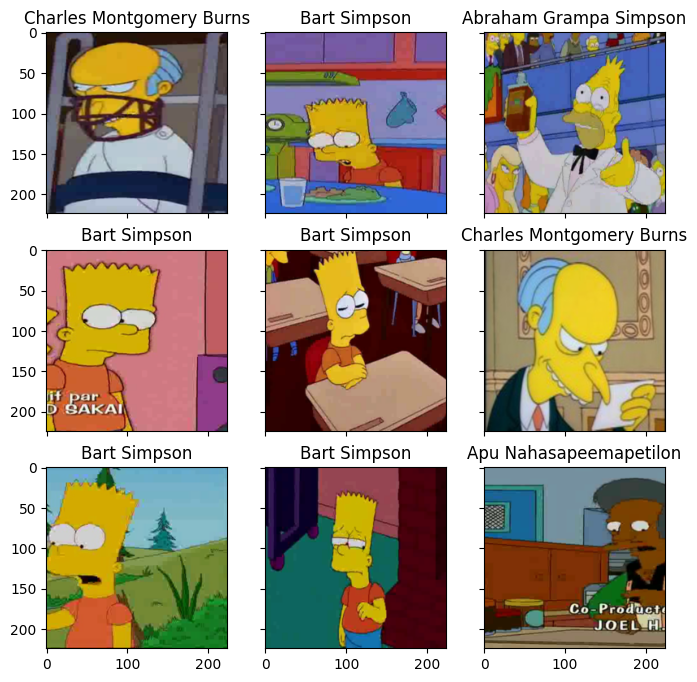

In [63]:
def preview(dataset):
    fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                            sharey=True, sharex=True)
    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0,1000))
        im_val, label = dataset[random_characters]
        img_label = " ".join(map(lambda x: x.capitalize(),\
                    dataset.label_encoder.inverse_transform([label])[0].split('_')))
        imshow(im_val.data.cpu(), \
              title=img_label,plt_ax=fig_x)
        im_val.data.to(DEVICE)
        im_val.to(DEVICE)



preview(val_dataset)



Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [14]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8) , 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16) , 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32) ,
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64) , 
            nn.ReLU(),
              
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96) , 
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [73]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    running_corrects.to(DEVICE)
    
    return train_loss, train_acc

In [16]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [77]:
def train(train_files, val_files, model, epochs, batch_size, path):
    model.to(DEVICE)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    best_model_wts = model.state_dict()
    best_acc = 0.0

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        criterion = nn.CrossEntropyLoss()

        opt= torch.optim.AdamW(model.parameters(), lr=3e-4 , amsgrad = True)

        

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)

             # если достиглось лучшее качество, то запомним веса модели
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()

                torch.save({
                            'epoch': epoch,
                            'model_state_dict': best_model_wts,
                            'optimizer_state_dict': opt.state_dict(),
                            
                            'loss': val_loss,
                            }, path)

            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)        
    return history

In [96]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).to(DEVICE)
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1)
    return probs

In [68]:
n_classes = len(np.unique(train_val_labels))



Запустим обучение сети.

In [47]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')


augm_transf_train = transforms.Compose([       
    transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)), 
                                
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.RandomResizedCrop(224 ,scale=(0.5, 1)),
    transforms.RandomRotation(50),
    transforms.GaussianBlur(13), 

    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),                    
])

train_augm_dataset = SimpsonsDataset(train_files, mode='train', transform = augm_transf_train)

train_dataset = SimpsonsDataset(train_files, mode='train')

train_dataset_new = train_dataset + train_augm_dataset

len(train_dataset_new)
len(train_augm_dataset)
len(train_dataset)


len(train_dataset_new)

31398

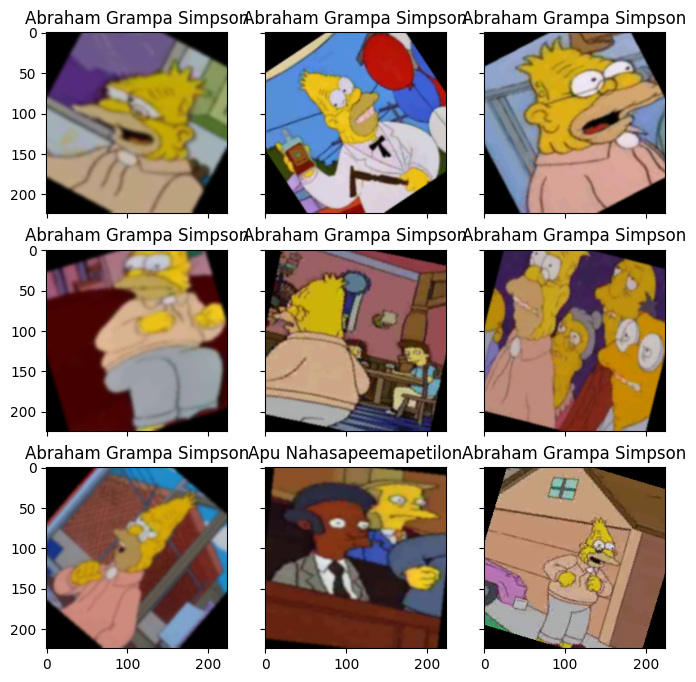

In [48]:
preview(train_augm_dataset)


In [122]:
import torchvision.models as models

resnet18 = models.resnet18(pretrained=True).to(DEVICE)



In [125]:
history = train(train_dataset_new, val_dataset, model= resnet18 , epochs=10, batch_size=64 ,  path="./resnet18.pt"   )

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.7489982448009042


epoch:  10%|█         | 1/10 [02:44<24:36, 164.04s/it]


Epoch 001 train_loss: 0.7490     val_loss 0.2534 train_acc 0.8590 val_acc 0.9341
loss 0.3919441891454824


epoch:  20%|██        | 2/10 [05:26<21:44, 163.06s/it]


Epoch 002 train_loss: 0.3919     val_loss 0.3440 train_acc 0.8971 val_acc 0.9119
loss 0.14701075304810488


epoch:  30%|███       | 3/10 [08:09<19:00, 162.97s/it]


Epoch 003 train_loss: 0.1470     val_loss 0.2647 train_acc 0.9616 val_acc 0.9358
loss 0.08450305721484003


epoch:  40%|████      | 4/10 [10:52<16:17, 162.99s/it]


Epoch 004 train_loss: 0.0845     val_loss 0.2308 train_acc 0.9769 val_acc 0.9431
loss 0.06648343696709051


epoch:  50%|█████     | 5/10 [13:35<13:34, 162.98s/it]


Epoch 005 train_loss: 0.0665     val_loss 0.1893 train_acc 0.9809 val_acc 0.9568
loss 0.06671435902735574


epoch:  60%|██████    | 6/10 [16:19<10:53, 163.25s/it]


Epoch 006 train_loss: 0.0667     val_loss 0.2229 train_acc 0.9813 val_acc 0.9482
loss 0.03790378570383119


epoch:  70%|███████   | 7/10 [19:01<08:08, 162.86s/it]


Epoch 007 train_loss: 0.0379     val_loss 0.2496 train_acc 0.9896 val_acc 0.9473
loss 0.02288634507129368


epoch:  80%|████████  | 8/10 [21:39<05:22, 161.33s/it]


Epoch 008 train_loss: 0.0229     val_loss 0.1751 train_acc 0.9931 val_acc 0.9643
loss 0.027367294531265022


epoch:  90%|█████████ | 9/10 [24:16<02:40, 160.15s/it]


Epoch 009 train_loss: 0.0274     val_loss 0.2376 train_acc 0.9914 val_acc 0.9463
loss 0.04303669793954959


epoch: 100%|██████████| 10/10 [26:53<00:00, 161.36s/it]


Epoch 010 train_loss: 0.0430     val_loss 0.1892 train_acc 0.9880 val_acc 0.9570


Построим кривые обучения

In [126]:
loss, acc, val_loss, val_acc = zip(*history)

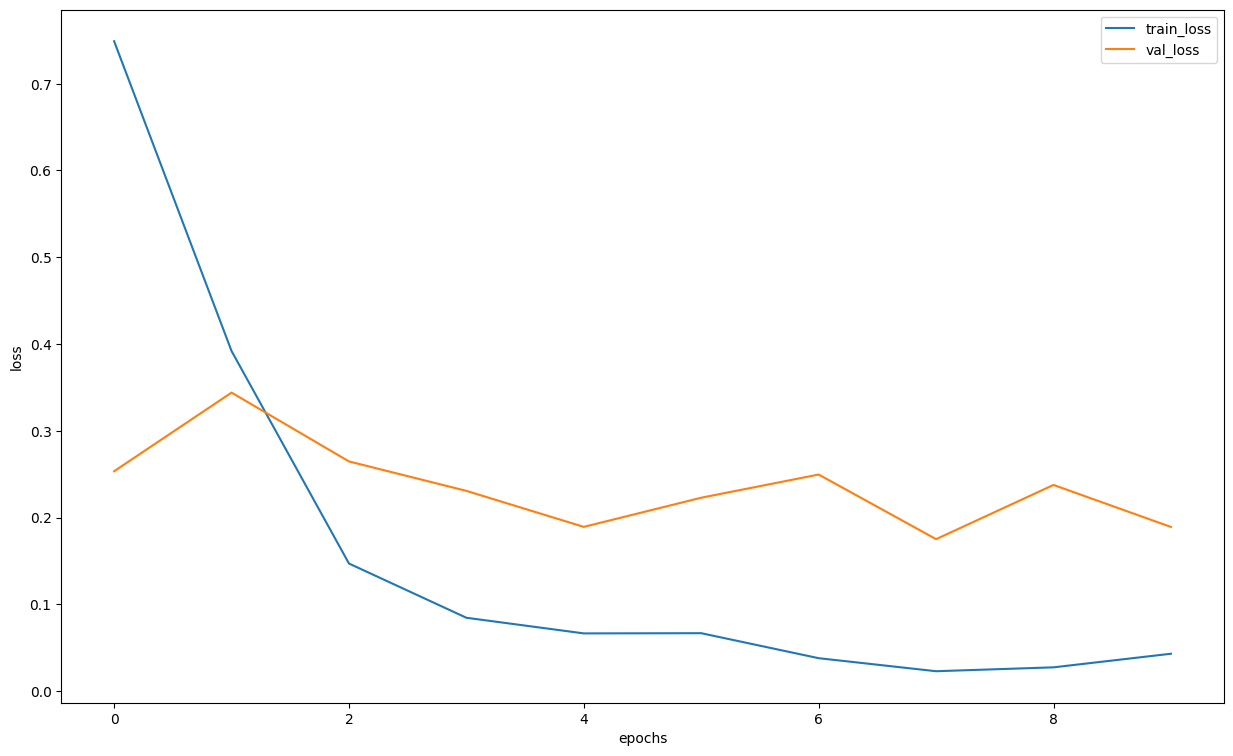

In [127]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [138]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1)
        probs.to(DEVICE)
        
        
    return probs

In [139]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(resnet18, ex_img.unsqueeze(0))

print(probs_im)
len(probs_im[0])

tensor([[2.0086e-20, 1.5274e-20, 1.0000e+00, 5.8787e-14, 2.5864e-15, 1.2387e-16,
         2.8716e-15, 3.1171e-19, 1.0412e-19, 3.4264e-22, 2.3062e-19, 1.0566e-18,
         2.3542e-18, 9.6306e-20, 1.9171e-21, 3.3930e-20, 1.7373e-22, 1.8315e-21,
         2.5585e-24, 5.7587e-22, 1.4235e-21, 4.2359e-20, 1.0955e-21, 4.9048e-22,
         1.7667e-18, 6.1829e-17, 2.5160e-21, 3.8442e-22, 1.3776e-18, 1.3136e-23,
         1.8990e-18, 1.0861e-19, 5.4688e-17, 3.5497e-13, 3.1189e-19, 8.3639e-21,
         1.6149e-20, 8.4904e-21, 3.8828e-23, 2.3537e-20, 2.5911e-20, 1.0397e-22,
         1.9255e-28, 7.3632e-27, 8.1014e-28, 3.3767e-26, 2.8957e-27, 1.5894e-26,
         8.4484e-27, 3.2808e-25, 3.7147e-23, 8.8080e-23, 2.2651e-26, 3.8634e-24,
         2.9439e-25, 1.9852e-24, 3.6278e-25, 1.2816e-23, 3.8586e-25, 7.9672e-25,
         9.6425e-24, 8.9134e-24, 5.8809e-24, 2.0416e-24, 3.4761e-23, 2.4458e-23,
         1.6110e-26, 4.3154e-24, 3.4515e-26, 1.3178e-25, 2.2749e-25, 3.1507e-24,
         4.8255e-23, 3.4964e

1000

In [140]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(resnet18, imgs)

print(probs_ims)
print(type(probs_ims))

tensor([[1.2422e-11, 1.1732e-09, 7.4869e-11,  ..., 2.1869e-14, 1.2636e-15,
         1.7976e-13],
        [2.6005e-17, 1.1588e-13, 1.6008e-18,  ..., 3.7392e-20, 1.8395e-22,
         1.9022e-19],
        [3.0518e-12, 4.0829e-13, 1.0000e+00,  ..., 3.6662e-16, 2.5928e-15,
         2.5610e-15],
        ...,
        [2.7314e-17, 2.1231e-17, 1.0000e+00,  ..., 5.7775e-22, 7.9315e-21,
         1.4691e-20],
        [1.0000e+00, 1.6169e-15, 8.0299e-18,  ..., 2.7426e-22, 1.5361e-19,
         1.0074e-23],
        [1.0000e+00, 1.2296e-09, 1.7735e-10,  ..., 8.7004e-14, 1.5473e-11,
         1.4979e-14]], device='cuda:0')
<class 'torch.Tensor'>


In [141]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
print(label_encoder.classes_)

['abraham_grampa_simpson' 'agnes_skinner' 'apu_nahasapeemapetilon'
 'barney_gumble' 'bart_simpson' 'carl_carlson' 'charles_montgomery_burns'
 'chief_wiggum' 'cletus_spuckler' 'comic_book_guy' 'disco_stu'
 'edna_krabappel' 'fat_tony' 'gil' 'groundskeeper_willie' 'homer_simpson'
 'kent_brockman' 'krusty_the_clown' 'lenny_leonard' 'lionel_hutz'
 'lisa_simpson' 'maggie_simpson' 'marge_simpson' 'martin_prince'
 'mayor_quimby' 'milhouse_van_houten' 'miss_hoover' 'moe_szyslak'
 'ned_flanders' 'nelson_muntz' 'otto_mann' 'patty_bouvier'
 'principal_skinner' 'professor_john_frink' 'rainier_wolfcastle'
 'ralph_wiggum' 'selma_bouvier' 'sideshow_bob' 'sideshow_mel'
 'snake_jailbird' 'troy_mcclure' 'waylon_smithers']


In [142]:
probs_ims = probs_ims.cpu()
probs_ims = probs_ims.numpy()

y_pred = np.argmax(probs_ims,-1)


print(y_pred)
actual_labels = [val_dataset[id][1] for id in idxs]
print(actual_labels)
#preds_class = [label_encoder.classes_[i] for i in y_pred]

#actual_class = [label_encoder.classes_[i] for i in actual_labels]



[6 6 2 6 6 3 6 0 0 4 4 0 4 4 4 6 2 2 0 0]
[6, 6, 2, 6, 6, 3, 6, 0, 0, 4, 4, 0, 4, 4, 4, 6, 2, 2, 0, 0]


Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [143]:
from sklearn.metrics import f1_score

f1_score(actual_labels , y_pred , average = 'weighted' )


1.0

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

TypeError: ignored

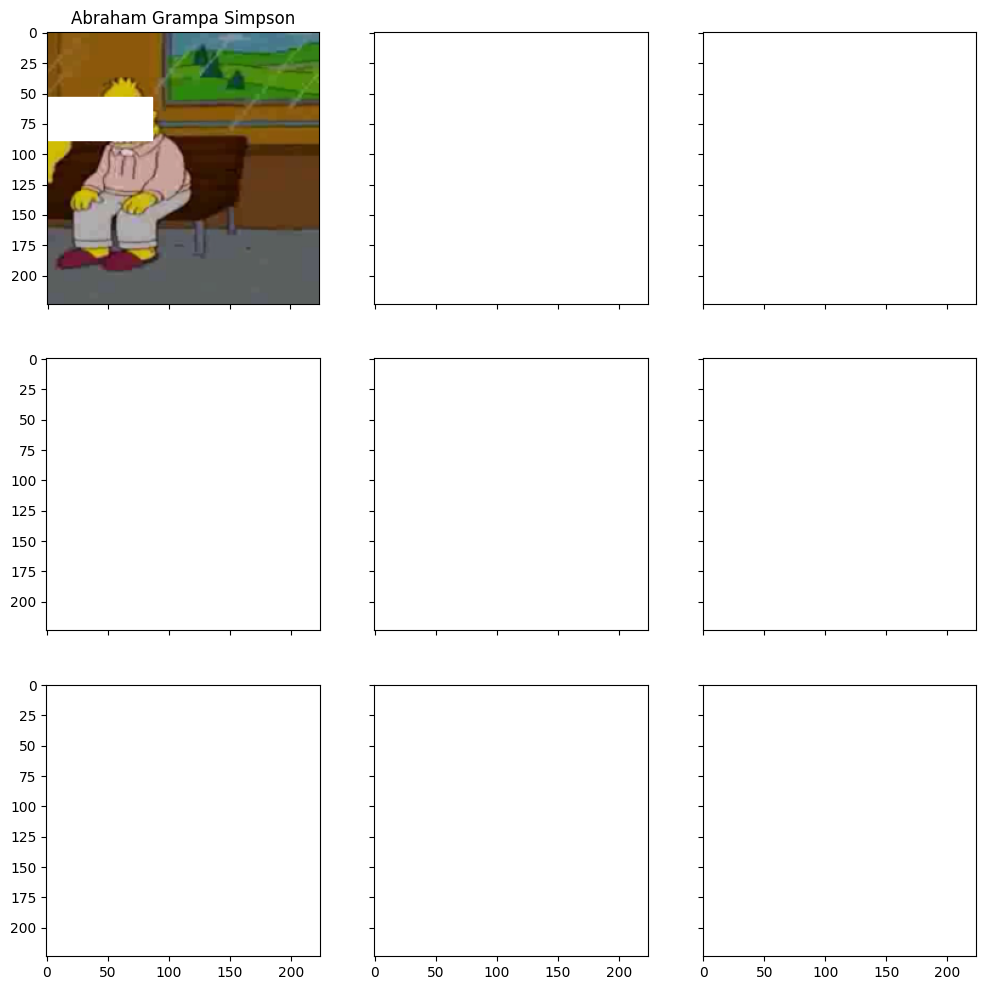

In [106]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [144]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(resnet18, test_loader)

probs = probs.cpu().numpy()

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [145]:
! ls 

best.csv  label_encoder.pkl	 resnet18.pt	   sample_data	train
gdrive	  mobilenet_v3_small.pt  resnet18subm.csv  test


In [146]:
import pandas as pd
#my_submit = pd.read_csv("/content/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [147]:
my_submit.to_csv('/content/resnet18subm_real.csv', index=False)

*Курсив*## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
